# Modules

In [45]:
%load_ext autoreload
%autoreload 2

import sys

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from sklearn import datasets, preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.metrics import (ConfusionMatrixDisplay, classification_report, confusion_matrix)
from sklearn.model_selection import train_test_split

from torch.optim import Adam
from torch.utils.data import DataLoader

from tqdm.autonotebook import tqdm

from scarf.model import Neural_Net
from dataset_samplers import RandomCorruptDataset, ClassCorruptDataset 
from utils import fix_seed, load_openml_list


seed = 1234
fix_seed(seed)

clf = LogisticRegression()
one_hot_encoder = preprocessing.OneHotEncoder(handle_unknown='ignore')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data

In [49]:
# Toy dataset
#dataset_name = 'breast_cancer'
#data = datasets.load_breast_cancer(as_frame=True)
#data, target = data["data"], data["target"]

# OpenML dataset
dataset_name = 'openml_6332'
data = load_openml_list([6332])[0]

/home/wei/ssl_tabular/utils.py:33: FutureWarning: Support for `output_format` of 'dict' will be removed in 0.15 and pandas dataframes will be returned instead. To ensure your code will continue to work, use `output_format`='dataframe'.
  openml_list = openml.datasets.list_datasets(dids)


Number of datasets: 1
Loading cylinder-bands 6332 ..


/home/wei/anaconda3/lib/python3.11/site-packages/openml/datasets/functions.py:438: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  warnings.warn(


In [37]:
train_data, test_data, train_target, test_target = train_test_split(
    data, 
    target, 
    test_size=0.2, 
    stratify=target, 
    random_state=seed
)





In [20]:
fraction_withLabel = 0.25
n_train_samples_labeled = int(len(train_data)*fraction_withLabel)
idxes_train_labeled = np.random.permutation(len(train_data))[:n_train_samples_labeled]
mask_train_labeled = np.zeros_like(train_target.to_numpy(), dtype=bool)
mask_train_labeled[idxes_train_labeled] = True

In [26]:
# to torch dataset with pair sampling: anchor and corrupt

# Random Sampling
train_dses, test_dses = {}, {}
train_dses['rand_corr'] = RandomCorruptDataset(
    train_data
)
test_dses['rand_corr'] = RandomCorruptDataset(
    test_data
)
# Oracle Class Sampling
train_dses['orc_corr'] = ClassCorruptDataset(
    train_data, 
    train_target.to_numpy() # oracle info on training labels
)
test_dses['orc_corr'] = ClassCorruptDataset(
    test_data, 
    np.ones(len(test_data)) # just the place holders
)
# Predicted Class Sampling
# Use a fraction of labeled samples

clf.fit(train_data.iloc[idxes_train_labeled], train_target.iloc[idxes_train_labeled])
train_predictions = clf.predict(train_data)

train_dses['cls_corr'] = ClassCorruptDataset(
    train_data, 
    np.where(mask_train_labeled, train_target.to_numpy(), train_predictions) # bootstrapped training labels
)
test_dses['cls_corr'] = ClassCorruptDataset(
    test_data, 
    np.ones(len(test_data)) # just the place holders
)


train_dses['rand_corr'].get_data().head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,-0.880353,-1.008502,-0.851600,-0.803450,0.528820,-0.257291,-0.443192,-0.407671,-0.129007,0.896290,...,-0.912743,-0.956058,-0.829103,-0.782999,0.427404,-0.216693,-0.214409,-0.123639,0.672669,0.366357
1,0.248449,1.482635,0.225824,0.152201,0.462742,-0.130230,0.414654,0.411382,-0.597113,0.266727,...,0.448496,1.198785,0.395258,0.279837,1.500623,-0.122839,0.611302,0.570670,-0.405498,0.563031
2,-1.345070,0.549036,-1.334836,-1.089839,0.609582,-0.812806,-0.856507,-0.939086,0.774546,0.461423,...,-1.133763,0.878470,-1.154989,-0.923432,0.906361,-0.870453,-1.018594,-1.198201,-0.042221,-0.059954
3,-0.139050,-0.389184,-0.190352,-0.253539,0.249823,-0.472841,-0.547939,-0.453825,-0.288671,-0.267620,...,-0.284796,-0.368815,-0.355786,-0.353509,-0.543816,-0.772100,-0.480259,-0.381195,-0.632129,-0.798305
4,1.054334,0.158496,0.884228,0.892295,-0.886724,-0.706354,-0.209267,0.167349,1.151934,-1.778288,...,0.876078,0.326818,0.631622,0.647473,-1.107034,-0.864668,-0.238274,0.045704,3.307260,-1.264719


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 128

train_loaders, models, optimizers, loss_histories = {}, {}, {}, {}
for key in ['rand_corr', 'cls_corr', 'orc_corr']:
    train_loaders[key] = DataLoader(train_dses[key], batch_size=batch_size, shuffle=True)
    models[key] = Neural_Net(
        input_dim=train_dses[key].shape[1], 
        emb_dim=16,
        corruption_rate=0.6,
        model_device=device
    ).to(device)
    optimizers[key] = Adam(models[key].parameters(), lr=0.001)
    loss_histories[key] = []

# Training

In [27]:
epochs = 7_500

for epoch in tqdm(range(1, epochs + 1)):
    for key in ['rand_corr', 'cls_corr', 'orc_corr']:
        epoch_loss = models[key].train_epoch(train_loaders[key], optimizers[key])
        loss_histories[key].append(epoch_loss)

# save the models and losses
for key in ['rand_corr', 'cls_corr', 'orc_corr']:
    model_filename = f'trained_models/{dataset_name}_{key}.pt'
    torch.save(models[key].state_dict(), model_filename)
    print(f"Model saved at {model_filename}!")
    loss_filename = f"trained_models/{dataset_name}_{key}_losses.npy"
    np.save(loss_filename, loss_histories[key])
    print(f"Model losses saved at {loss_filename}!")

  0%|          | 0/7500 [00:00<?, ?it/s]

# [Optional] Load previously trained models and their losses

In [40]:
for key in ['rand_corr', 'cls_corr', 'orc_corr']:
    model_filename = f'trained_models/{dataset_name}_{key}.pt'
    models[key].load_state_dict(torch.load(model_filename))
    print(f"Model loaded from {model_filename}!")
    loss_filename = f"trained_models/{dataset_name}_{key}_losses.npy"
    loss_histories[key] = np.load(loss_filename)
    print(f"Model losses loaded from {loss_filename}!")

Model loaded from trained_models/breast_cancer_rand_corr.pt!
Model losses loaded from trained_models/breast_cancer_rand_corr_losses.npy!
Model loaded from trained_models/breast_cancer_cls_corr.pt!
Model losses loaded from trained_models/breast_cancer_cls_corr_losses.npy!
Model loaded from trained_models/breast_cancer_orc_corr.pt!
Model losses loaded from trained_models/breast_cancer_orc_corr_losses.npy!


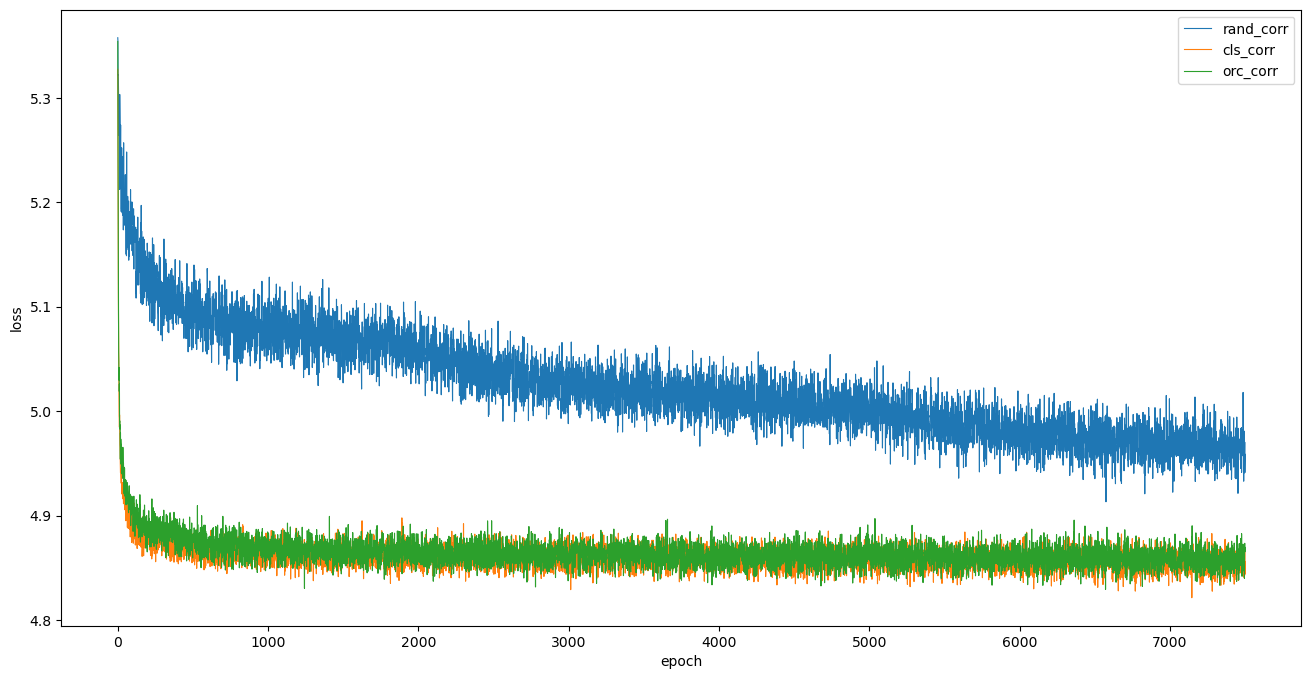

In [41]:
fig, ax = plt.subplots(figsize=(16, 8))
for key in ['rand_corr', 'cls_corr', 'orc_corr']:
    ax.plot(loss_histories[key], label=key, linewidth=0.8)
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.legend()

# Evaluate embeddings

In [42]:
train_loader = DataLoader(train_dses['rand_corr'], batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dses['rand_corr'], batch_size=batch_size, shuffle=False)

# get embeddings for training and test set
train_embeddings, test_embeddings = {}, {}
for key in ['rand_corr', 'cls_corr', 'orc_corr']:
    train_embeddings[key] = models[key].get_dataset_embeddings(train_loader)
    test_embeddings[key] = models[key].get_dataset_embeddings(test_loader)

In [43]:
# Supervised learning baseline: train the classifier on the fractionally labeled original data
clf.fit(train_data.iloc[idxes_train_labeled], train_target.iloc[idxes_train_labeled])
test_predictions = clf.predict(test_data)
print("Classification report for direct fitting inputs:")
print(classification_report(test_target, test_predictions))


# embeddings dataset: train the classifier on the embeddings
for key in ['rand_corr', 'cls_corr', 'orc_corr']:
    clf.fit(train_embeddings[key][idxes_train_labeled], train_target.iloc[idxes_train_labeled])
    test_predictions = clf.predict(test_embeddings[key])
    print(f"Classification report using {key} embeddings:")
    print(classification_report(test_target, test_predictions))

Classification report for direct fitting inputs:
              precision    recall  f1-score   support

           0       1.00      0.93      0.96        42
           1       0.96      1.00      0.98        72

    accuracy                           0.97       114
   macro avg       0.98      0.96      0.97       114
weighted avg       0.97      0.97      0.97       114

Classification report using rand_corr embeddings:
              precision    recall  f1-score   support

           0       1.00      0.95      0.98        42
           1       0.97      1.00      0.99        72

    accuracy                           0.98       114
   macro avg       0.99      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114

Classification report using cls_corr embeddings:
              precision    recall  f1-score   support

           0       1.00      0.95      0.98        42
           1       0.97      1.00      0.99        72

    accuracy                      

# Visualzie using t-sne 

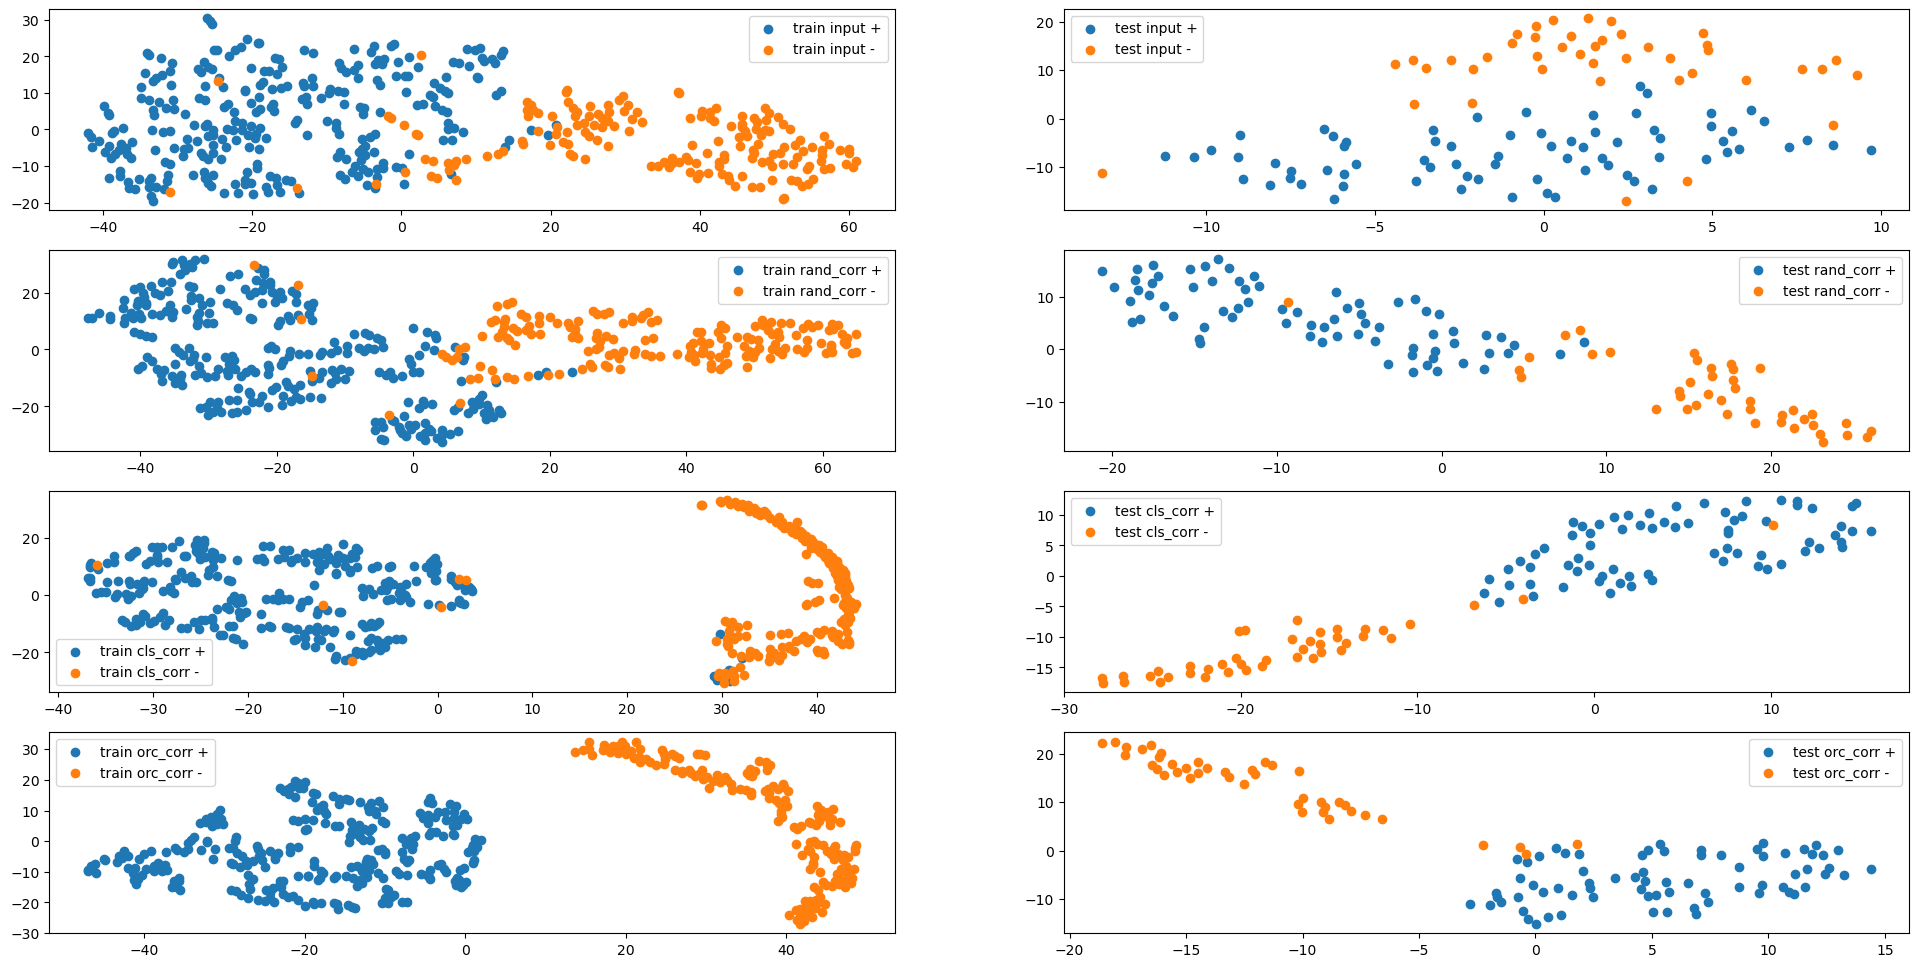

In [44]:
fig, axes = plt.subplots(4,2,figsize=(24, 12))

tsne = TSNE(n_components=2, learning_rate="auto", init="pca", perplexity=15)
# first plot the original input reduced down to 2 dimensions
reduced = tsne.fit_transform(train_data.to_numpy())
positive = train_target == 1
axes[0][0].scatter(reduced[positive, 0], reduced[positive, 1], label=f"train input +")
axes[0][0].scatter(reduced[~positive, 0], reduced[~positive, 1], label=f"train input -")
axes[0][0].legend()

reduced = tsne.fit_transform(test_data.to_numpy())
positive = test_target == 1
axes[0][1].scatter(reduced[positive, 0], reduced[positive, 1], label=f"test input +")
axes[0][1].scatter(reduced[~positive, 0], reduced[~positive, 1], label=f"test input -")
axes[0][1].legend()


for row_id, key in enumerate(['rand_corr', 'cls_corr', 'orc_corr']):
    reduced = tsne.fit_transform(train_embeddings[key])
    positive = train_target == 1
    axes[row_id+1][0].scatter(reduced[positive, 0], reduced[positive, 1], label=f"train {key} +")
    axes[row_id+1][0].scatter(reduced[~positive, 0], reduced[~positive, 1], label=f"train {key} -")
    axes[row_id+1][0].legend()

    reduced = tsne.fit_transform(test_embeddings[key])
    positive = test_target == 1
    axes[row_id+1][1].scatter(reduced[positive, 0], reduced[positive, 1], label=f"test {key} +")
    axes[row_id+1][1].scatter(reduced[~positive, 0], reduced[~positive, 1], label=f"test {key} -")
    axes[row_id+1][1].legend()

plt.show()